# 範例重點
學習如何在 keras 中加入 model checkpoint <br />
知道如何設定監控目標 <br />
比較使用最佳與非最佳參數時的 performance

In [0]:
import os 
import keras

#os.environ["CUDA_VISIBLE_DEVICES"] = " "
!nvidia-smi

Mon Jul 22 12:54:12 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    26W /  70W |    357MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
(train_x, train_y), (test_x, test_y) = keras.datasets.cifar10.load_data()

In [0]:
def preproc_x(x, flatten = True):
  x = x/255.0
  if flatten:
    x = x.reshape((len(x),-1))
  return x

def preproc_y(y, num_classes = 10):
  if y.shape[-1] == 1 :
    y = keras.utils.to_categorical(y, num_classes)
  return y

In [0]:
train_x = preproc_x(train_x)
test_x = preproc_x(test_x)
train_y = preproc_y(train_y)
test_y = preproc_y(test_y)

In [0]:
def build_mlp(input_shape, output_units = 10, num_neurons = [512, 256, 128]):
  
  input_layer = keras.layers.Input(input_shape)
  
  for i, n_units in enumerate(num_neurons):
    if i == 0:
      x = keras.layers.Dense(units = n_units, name = 'hidden_layer_'+str(i+1))(input_layer)
      x = keras.layers.BatchNormalization()(x)
      x = keras.layers.Activation('relu')(x)
  else:
      x = keras.layers.Dense(units = n_units, name = 'hidden_layer_'+str(i+1))(x)
      x = keras.layers.BatchNormalization()(x)
      x = keras.layers.Activation('relu')(x)
      
  output_layer = keras.layers.Dense(units = output_units, activation = 'softmax')(x)
  model = keras.models.Model(inputs = [input_layer], outputs = [output_layer])
  return model

In [0]:
lr = 1e-3
momentum = 0.95
epochs = 50
batch_size = 1024

In [0]:
checkpoint_path = "./tmp.h5"

model_ckpt = keras.callbacks.ModelCheckpoint(filepath = checkpoint_path, monitor = 'val_loss', save_best_only = True)

In [0]:
model = build_mlp(train_x.shape[1:])
optimizer = keras.optimizers.SGD(lr = lr, nesterov = True, momentum = momentum)
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ['accuracy'])
model.summary()

history = model.fit(train_x, train_y, epochs = epochs, batch_size = batch_size, shuffle = True,
                                  validation_data = [test_x, test_y], callbacks = [model_ckpt])


#Load back
model = keras.models.load_model(checkpoint_path)
loss_loadback, acc_loadback = model.evaluate(test_x, test_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
batch_normalization_11 (Batc (None, 512)               2048      
_________________________________________________________________
activation_11 (Activation)   (None, 512)               0         
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 128)               65664     
_________________________________________________________________
batch_normalization_12 (Batc (None, 128)               512       
_________________________________________________________________
activation_12 (Activation)   (None, 128)               0         
__________

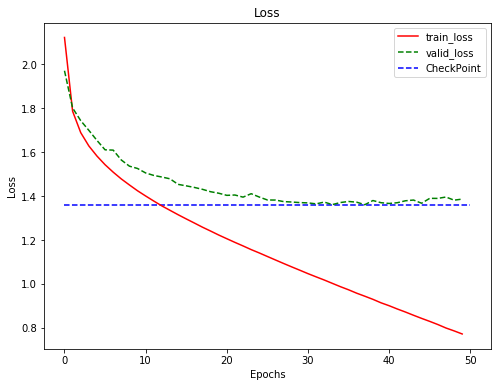

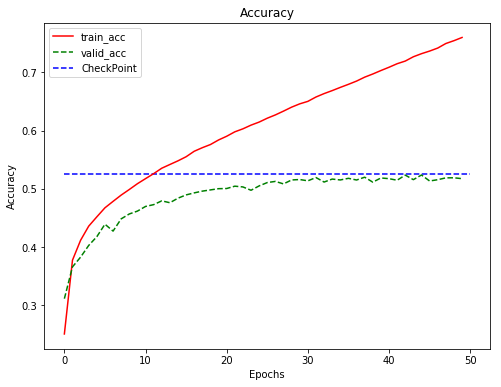

In [0]:
import matplotlib.pyplot  as plt
%matplotlib inline

plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], '-', label = 'train_loss', color = 'r')
plt.plot(history.history['val_loss'], '--', label = 'valid_loss', color = 'g')
plt.hlines(y = loss_loadback, xmin = 0, xmax = len(history.history['loss']), label = 'CheckPoint', color = 'b', linestyles = '--')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(history.history['acc'], '-', label = 'train_acc', color = 'r')
plt.plot(history.history['val_acc'], '--', label = 'valid_acc', color = 'g')
plt.hlines(y = acc_loadback, xmin = 0, xmax = epochs, label = 'CheckPoint', color = 'b', linestyles = '--')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Work
試比較 save_best_only 與否的差異 <br />
請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [0]:
check_point2 = keras.callbacks.ModelCheckpoint(filepath = './tmp.h5', monitor = 'val_loss', save_best_only = False)

In [0]:
model = build_mlp(train_x.shape[1:])
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ['accuracy'])
model.summary()

history2 = model.fit(train_x, train_y, batch_size = batch_size, epochs = epochs, shuffle = True, validation_data = [test_x, test_y], callbacks = [check_point2])

model = keras.models.load_model('./tmp.h5')
loss_loadback2, acc_loadback2 = model.evaluate(test_x, test_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
batch_normalization_15 (Batc (None, 512)               2048      
_________________________________________________________________
activation_15 (Activation)   (None, 512)               0         
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 128)               65664     
_________________________________________________________________
batch_normalization_16 (Batc (None, 128)               512       
_________________________________________________________________
activation_16 (Activation)   (None, 128)               0         
__________

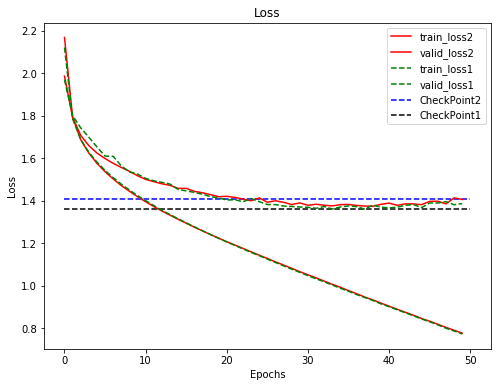

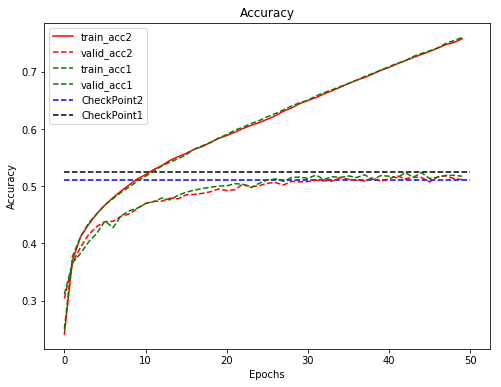

In [0]:
plt.figure(figsize=(8,6))
plt.plot(history2.history['loss'], '-', label = 'train_loss2', color = 'r')
plt.plot(history2.history['val_loss'], '-', label = 'valid_loss2', color = 'r')
plt.plot(history.history['loss'],'--',label = 'train_loss1', color = 'g')
plt.plot(history.history['val_loss'],'--',label = 'valid_loss1', color = 'g')
plt.hlines(y = loss_loadback2, xmin = 0, xmax = epochs, label = 'CheckPoint2', color = 'b', linestyles = '--')
plt.hlines(y = loss_loadback, xmin = 0, xmax = epochs, label = 'CheckPoint1', color = 'black', linestyles = '--')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(history2.history['acc'], '-', label = 'train_acc2', color = 'r')
plt.plot(history2.history['val_acc'], '--', label = 'valid_acc2', color = 'r')
plt.plot(history.history['acc'],'--',label = 'train_acc1', color = 'g')
plt.plot(history.history['val_acc'],'--',label = 'valid_acc1', color = 'g')
plt.hlines(y = acc_loadback2, xmin = 0, xmax = epochs, label = 'CheckPoint2', color = 'b', linestyles = '--')
plt.hlines(y = acc_loadback, xmin = 0, xmax = epochs, label = 'CheckPoint1', color = 'black', linestyles = '--')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
model = build_mlp(train_x.shape[1:])
optimizer = keras.optimizers.SGD(lr = lr, nesterov = True, momentum = momentum)
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ['accuracy'])
model.summary()

history = model.fit(train_x, train_y, epochs = epochs, batch_size = batch_size, shuffle = True,
                                  validation_data = [test_x, test_y], callbacks = [model_ckpt])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
batch_normalization_17 (Batc (None, 512)               2048      
_________________________________________________________________
activation_17 (Activation)   (None, 512)               0         
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 128)               65664     
_________________________________________________________________
batch_normalization_18 (Batc (None, 128)               512       
_________________________________________________________________
activation_18 (Activation)   (None, 128)               0         
__________

# Reset the ipynb

In [44]:
#Load back
model = keras.models.load_model('./tmp.h5')
loss_loadback, acc_loadback = model.evaluate(test_x, test_y)

10000/10000 [==============================] - 1s 107us/step


In [47]:
print(f"validation loss : {loss_loadback}, validation accuracy : {acc_loadback}")

validation loss : 1.4058805702209474, validation accuracy : 0.5116
